In [1]:
import scanpy as sc
import csv

# Load the processed data
adata = sc.read_h5ad("/Users/aumchampaneri/Databases/Triple/Human_Nor-CKD-AKF_scRNA_processed.h5ad")

# Load the gene dictionary from the csv file
gene_dict = {}
with open('complement_gene_dictionary.csv', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        gene_dict[row[0]] = row[1]



In [12]:
adata

AnnData object with n_obs × n_vars = 225151 × 29893
    obs: 'orig.ident', 'nCount_RNA', 'SpecimenID', 'LibraryID', 'SampleID', 'Run', 'clusterNumber', 'subclass.l1', 'dataSource', 'diseasetype', 'Race', 'clusterClass', 'organism_ontology_term_id', 'assay_ontology_term_id', 'sampletype', 'disease_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_ontology_term_id', 'tissue_type', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'Age_binned', 'cell_type_ontology_term_id', 'author_cell_type', 'diabetes_history', 'hypertension', 'eGFR', 'is_primary_data', 'disease_category', 'nFeature_RNA', 'percent.mt', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes'
    var: 'index', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells'
    uns: 'batch_condition', 'citation', 'def

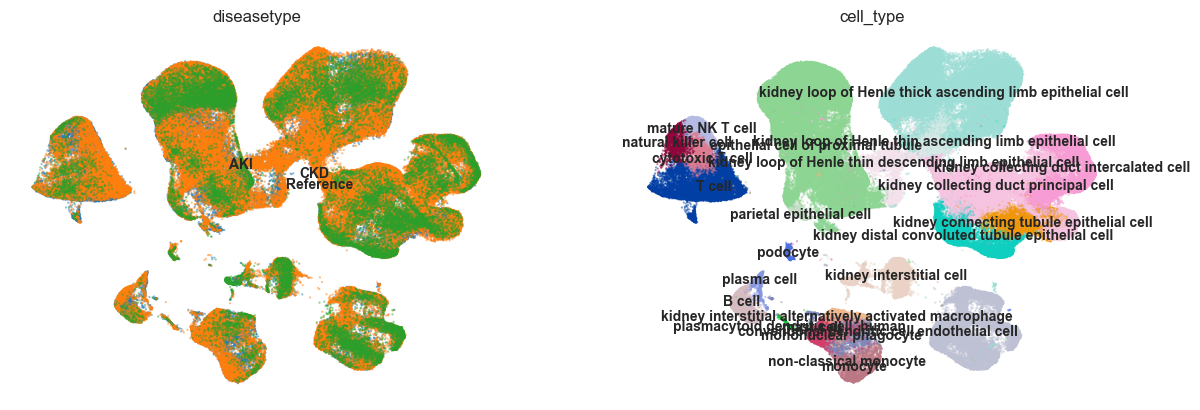

In [20]:
sc.pl.umap(adata, color=['diseasetype', 'cell_type'], size=10, alpha=0.5, legend_loc='on data', frameon=False, show=True)

In [24]:
# print the number of unique diseaseetype values and the unique values themselves
print(len(adata.obs['diseasetype'].unique()))

print(adata.obs['diseasetype'].unique())

# print the numebr of entire for each disease type
print(adata.obs['diseasetype'].value_counts())

3
['Reference', 'AKI', 'CKD']
Categories (3, object): ['AKI', 'CKD', 'Reference']
diseasetype
CKD          130612
AKI           51161
Reference     43378
Name: count, dtype: int64


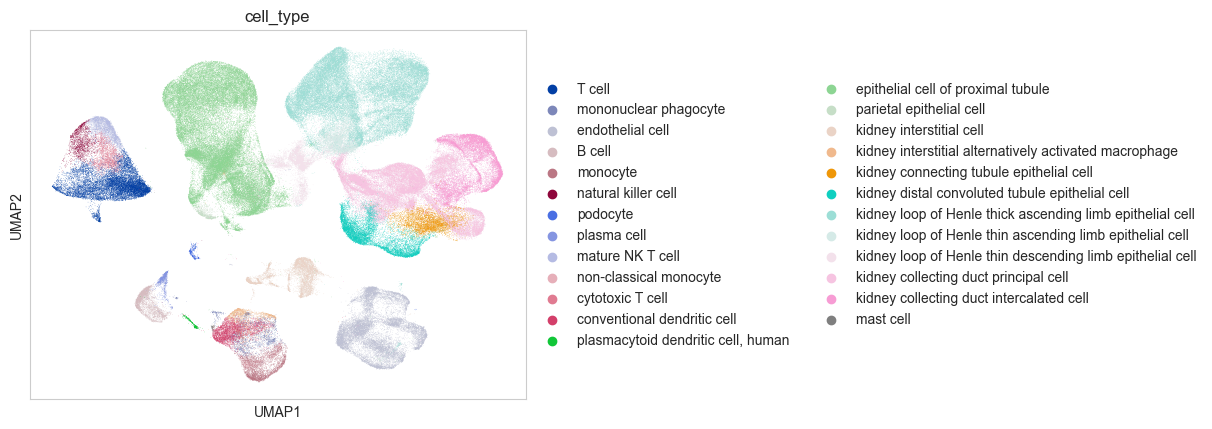

In [25]:
sc.pl.umap(adata, color='cell_type')

In [29]:
# Find all the cell types in the data
cell_types = adata.obs['cell_type'].unique()
for cell_type in cell_types:
    print(cell_type)

kidney collecting duct principal cell
kidney interstitial cell
kidney loop of Henle thin descending limb epithelial cell
endothelial cell
epithelial cell of proximal tubule
kidney loop of Henle thick ascending limb epithelial cell
kidney loop of Henle thin ascending limb epithelial cell
kidney collecting duct intercalated cell
cytotoxic T cell
non-classical monocyte
conventional dendritic cell
T cell
kidney interstitial alternatively activated macrophage
mature NK T cell
plasma cell
mononuclear phagocyte
monocyte
B cell
natural killer cell
plasmacytoid dendritic cell, human
mast cell
kidney distal convoluted tubule epithelial cell
podocyte
parietal epithelial cell
kidney connecting tubule epithelial cell


In [44]:
import yaml

# Load from YAML
with open("Tissue Type Dictionary.yaml", "r") as file:
    cell_type_groups = yaml.safe_load(file)



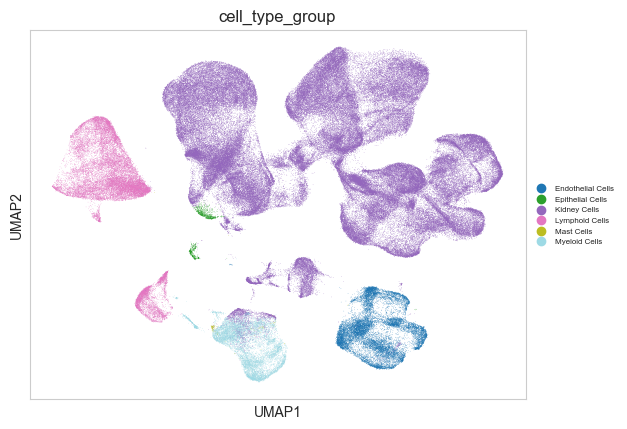

In [46]:
sc.pl.umap(adata,
           color=['cell_type_group'],
           legend_fontsize='xx-small',
           legend_fontweight='light',

           # save='_cell-type-group_nor1.pdf'
           )